In [47]:
import cv2 as cv
import os
import numpy as np
import subprocess as sp

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

%matplotlib inline

# Term Project Data Cleaning and Visualization

## Problem Statement and Goal

**TLDR: Teach computers object permenance by creating a new method to show continuity of objects as they change shape and move in frame.**

Essentially, we are teaching a computer object permanance. We will be analyzing videos ranging from simple with single objects in the foreground, like a dog walking on grass, to complex with lots of objects in motion, like a city street. We are less concerned about doing a classification of the objects in the frame. This is already fairly well understood on still images; instead we hope to develop a method to detect objects that undergo significant changes in boundary shape during the course of the video. In theory this should allow us to identify objects retroactively, if they are labelled in any single frame, and then by using object persistence we can extrapolate backwards. The BHAG(big hairy audacious goal) of this project is to do this at a 24-90fps to allow for live detection in streaming video. On standard definition this is roughly 8-28 million pixels per minute and at HD video this is 50-190 million pixels per minute. Significant milestones will be creating the data pipeline, determining the correct recipe of image processing on the frames, and the creation of a new method of object/blob detection.

## Underlying assumtions and questions to answer

**TLDR: We assume the objects in the video aren't moving too fast relative to the camera's motion.**

Part of the difficulty in tuning an algorithm to detect object permenance is that videos differ wildly. For this project, I have selected several different video clips that are of the same high quality, but have unique properties. The clips were chosen to test robustness of a new segmentation method. They cover a variety of focal lengths, color schemes, camera work, etc... I will discuss the challenges of these attributes in-depth so that when we analyze the clips, it is easier to understand why certain approaches succeed and others fail for different types of clips. 

Our assumptions about the clips are threefold: first, that the motions of objects in the video are interpolated with a high degree of accuracy by the frames; second, that objects do no dissappear or reappear except at the edges of the frame; lastly, that object interactions are simple and limited to occlusion. The first assumption is necessary for us to trust any results from this type of algorithm. The second assumption drastically limits the amount of redefining new objects, if objects are allowed to appear from the background then we can't ignore noisy background data because it might contain new objects. The last assumption is the least binding, and our end goal is to make it unecessary.


## Clip Attributes

**Camera**:
There are three main categories of camera motion that we will have to account for: fixed relative to background, fixed relative to foreground, and dynamic camera motions, like tilt and pan. Most clips will be fixed in some regard, but it is important to prepare for dynamic motions as these are common in robotics applications.

**Scene**:
This encompasses a large set of characteristics that boil down to how cluttered our images are. The simplest scene consists of a single object on a plain background. Complex scenes have many many moving objects, like a crowded city street or a flock of birds. It is difficult to pinpoint what constitutes many, but it seems that more than five objects becomes unmanagable.
    
**Background**:
The background of the image largely depends on how the camera is moving, however there are minute but important differences in the classes of background. Loosely there are three classes of background: constant, fluctuating, and chaotic. 
    
-Constant backgrounds have a completely static background. They most often appear with a fixed camera, they are good candidates for the BackgroundSubtraction algorithmns, but those may not produce useful resluts if the scene is sufficiently complex. Generally speaking, it is the easiest class of background to work with.
    
-Fluctuating backgrounds are regions that change during the video but are somewhat predictable in their behavior. A classic example would be the motioned blurred backgrounds when the camera is in a moving vehicle or ocean waves in a beach scene. These types of backgrounds can pose challenges to edge detection algorithmns because they create lots of noise from frame to frame.
    
-Chaotic backgrounds occur when the whole scene is in flux. They arise when the camera is panning or if the scene is so complex that there is no discernable background. If the motion of the tilt is known then Kalman Filters may be able to produce useful results if it has been expanded to account for multiple objects.


## Data Acquisition

 **TLDR: I created a data pipeline that extracts frames from video clips and runs various common image processing algorithms on them**
 
The pipeline starts off with a common video file (.mp4, .mov, .avi etc...) and extracts each of the frames to create an array of images. I then compute the changes between frames, find edges on those differences and then use the watershed algorithm to do basic segmentation. The watershed algorithim appears to have difficulties on all but the simplest of video clips. 

I have chosen video clips that represent many of the common combinations of backgrounds, camera movements and scene complexities. They are by no means exhaustive, but they should serves as a good test set for the object permenance algorithm. One of the benefits of using generic scenes is that it will test the robustness of the algorithm thoroughly.  The opencv library is also capable of streaming video from devices and I hope to incorporate as a final demonstration of the algorithm's speed. 

In [15]:
#creates necessary path variables to construct the data and store it for later use

origin = os.getcwd()
raw_subfolder = 'raw'
diff_subfolder = 'diff'
segmented_subfolder = 'segmented'
canny_subfolder = 'canny'
cannydiff_subfolder = 'cannydiff'
subfolders = [raw_subfolder, diff_subfolder,canny_subfolder,segmented_subfolder,cannydiff_subfolder]
#subfolders = [raw_subfolder, diff_subfolder,canny_subfolder]


In [3]:
os.chdir(origin)


**Extracting Images From Video Frames**

In [ ]:

cwd = os.getcwd()
cwd += "\Videos"
os.chdir(cwd)

cwd = os.getcwd()

for root, directiories, filenames in os.walk(cwd):
    #run the operation on each video
    for f in filenames:
        
        dir_name = f[:-4]
        #check if there's a folder for the video clip and if not make one
        if not os.path.exists(cwd+"\\"+dir_name):
            os.mkdir(dir_name)
    
            #create a directory for the raw images and return to the main directory
            os.chdir(cwd+"\\"+dir_name)
            
            os.mkdir(raw_subfolder)
            
            os.chdir(cwd)
        
            #Create a series of images from the frames of the video clip
            cmd='ffmpeg -i {} {}_%04d.jpg'.format(f,dir_name,)
            sp.call(cmd,shell=True)


            #Move the frames to their designated folder
            move_file = 'move {}\\*.jpg {}'.format(cwd,cwd+"\\"+dir_name+"\\"+raw_subfolder)
            sp.call(move_file,shell=True)


            #return to the video folder for the next video file
        os.chdir(origin)
        os.chdir(cwd)

os.chdir(origin)
            
            

## Data Cleaning and Preparation

Cleaning data poses an interesting set of challenges for image processing. We could do things like anisotropic diffusion to accentuate regions of color or convolve the image with a variety of smoothing/sharpening kernels, but ultimately those are expensive operations to run on large images and the results aren't always necessary for good images. Instead I've opted to run a small cheap set of operations that should elucidate motion in the video clip. The working hypothesis for the object permaneance algorithm is to create a minimally sufficient set of voronoi points that describe the objects in the scene. 

Our first set of operations aims to reduce the images to a very sparse set of meaningful pixels which we will then run noise reduction on.

### Image Difference
Finding the difference between two images helps establish the background, find objects in the foreground and is essential to discerning what is happening in a video clip. I have tried to optimize the process by paring down the amount of data being used by moving from colored to greyscale which reduced the amount of information by a factor of 3. This does pose a problem for certain kinds of scenes where the contrast between grayscale is small, but there are distinct colors. See Visualizations **bugs** for an example.

In [ ]:
def image_diff(path, subfolder):
    """
    Creates a series of images taken from the difference between sequential frames.
    This helps us identify which parts of the image are moving and helps us extract a
    background from certain kinds of videos.
    """
    
    #load necessessary file path information and images
    path_raw = path + "\\" + raw_subfolder
    files = os.listdir(path_raw)

    
    
    image_old = cv.imread(path_raw + "\\"+files[0])
    image_old_grey = cv.cvtColor(image_old, cv.COLOR_BGR2GRAY)
   
    for f in files[1:-1]:
#    for f in files[1:10]:

        #read in the next image and convert it to grayscale
        image_new = cv.imread(path_raw + "\\" + f)
        image_new_grey = cv.cvtColor(image_new, cv.COLOR_BGR2GRAY)

        #subtract the two pictures pixel by pixel
        image_diff = cv.subtract(image_old_grey,image_new_grey)

        
        #Save the image to the diff_subfolder
        cv.imwrite(subfolder+"\\"+f ,image_diff)

        #update the current for next loop
        image_old_grey = image_new_grey

### Image Segmentation
Image segmentation and finding regions of interest is another key step in establishing which objects are in the scene and how they're moving. I chose the watershed algorithm initially after seeing impressive results from it, but have found it to be too time consuming and haven't been thrilled by how it performs on complex images. See Visualizations

In [ ]:
def image_segmentation(path,subfolder):
    
    #load the necessary information
    path_raw = path + "\\" + raw_subfolder
    files = os.listdir(path_raw)
    
    for f in files[::20]:
#    for f in files[1:10]:

        # read in the next image and convert it to grayscale and threshold it
        image = cv.imread(path_raw + "\\" + f)
        image_grey = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        ret, thresh = cv.threshold(image_grey,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
        
    
        # noise removal
        kernel = np.ones((3,3),np.uint8)
        opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
        
        # Finding sure background area
        sure_bg = cv.dilate(opening,kernel,iterations=3)
        
        # Finding sure foreground area
        dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5) 
        ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
       
        
        # Finding unknown region
        sure_fg = np.uint8(sure_fg)
        unknown = cv.subtract(sure_bg,sure_fg)

        # Marker labelling
        ret, markers = cv.connectedComponents(sure_fg)
    
        # Add one to all labels so that sure background is not 0, but 1
        markers = markers+1
          
        # Now, mark the region of unknown with zero
        markers[unknown==255] = 0
        
        markers = cv.watershed(image,markers)
        
        # draws outlines on the original 
        image[markers == -1] = [255,0,0]

        # Save the image to the diff_subfolder       
        mpimg.imsave(subfolder+"\\"+f,markers)
#       cv.imwrite(subfolder+"\\"+f , image)

        

### Edge Detection
Edge detection helps further narrow down regions of interest and could be a good starting point for creating the set of boundary points for each object in scene. It is efficient and the results are very useful. I ran this on both the original image and the sparse diff image to generate two different ways of viewing motion transforms. I chose the Canny edge detection algorithm for its speed. see Visualizations

In [ ]:
def canny_edge(path, subfolder, mode):
     
    if mode == 'diff':
        path_raw = path + "\\" + diff_subfolder
    elif mode == 'raw':
        path_raw = path + "\\" + raw_subfolder
    else:
        raise ValueError('invalid mode used')
        
    print path_raw
    files = os.listdir(path_raw)
    print files
   
   
    for f in files:
#    for f in files[1:10]:

        #read in the next image and convert it to grayscale
        image_new = cv.imread(path_raw + "\\" + f)
        edge = cv.Canny(image_new,75,75)

        
        #Save the image to the diff_subfolder
        cv.imwrite(subfolder+"\\"+f ,edge)


### Running the Operations

The code below finds which operations haven't been calculated on a data set and creates a corresponding folder for the processed images to go into. The different operations are non-destructive so that the images are preserved for later calculation and comparison. This does increase the spatial complexity significantly, approximately by a factor of 30.

In [ ]:
#establish base variables 
cwd = os.getcwd()
cwd += "\Videos"

#move into the appropriate directory
os.chdir(cwd)

#generate the list of files and folders in the Videos folder
directories = os.listdir(cwd)
directories= directories[::2] #we're assuming the only things in this folder are our video files and their related subfolders


    #only go through the top level folders for each video clip, not the subfolders' folders
for directory in directories:
    path_vid_subfolder = cwd + "\\" + directory
    os.chdir(path_vid_subfolder)
   
    #for each subfolder do an action 
    for subfolder in subfolders: 

        subfolder_path = path_vid_subfolder+"\\"+subfolder
        #check that the subfolder doesn't already exist and if it doesn't create it and run the appropriate action
        if not os.path.exists(subfolder_path):

            os.mkdir(subfolder)

            if subfolder == raw_subfolder:
                pass                    
            elif subfolder == diff_subfolder:
                image_diff(os.getcwd(),subfolder)
            elif subfolder == segmented_subfolder:
                image_segmentation(os.getcwd(),subfolder)
            elif subfolder == canny_subfolder:
                canny_edge(os.getcwd(),subfolder,'raw')
            elif subfolder == cannydiff_subfolder:
                canny_edge(os.getcwd(),subfolder,'diff')

    #after processing the photos return to the Video folder
    os.chdir(cwd)


os.chdir(origin)

In [ ]:
#code that was solely useful in debugging
os.chdir(origin)
print origin
print cv.__version__

In [107]:

def imcompare(path_left_image, path_right_image, title_left, title_right ,color_left = "Greys", color_right = "Greys" ):
    image_left = plt.imread(origin+"\\"+path_left_image)
    image_right = plt.imread(origin+"\\"+path_right_image)

    fig = plt.figure(figsize= (20,16))
    plt.subplot(121)
    plt.title(title_left)
    plt.imshow(image_left, cmap = color_left)

    plt.subplot(122)
    plt.imshow(image_right, cmap = color_right)

    plt.title(title_right)
    plt.show()

## Data Visualiaztion and Comparisons

Below are comparisons for the different operations and how they are useful on specific videos as well as where they fail on specific videos

**Several Different Video Files**

These are snapshots from some of the clips I used to generate my data

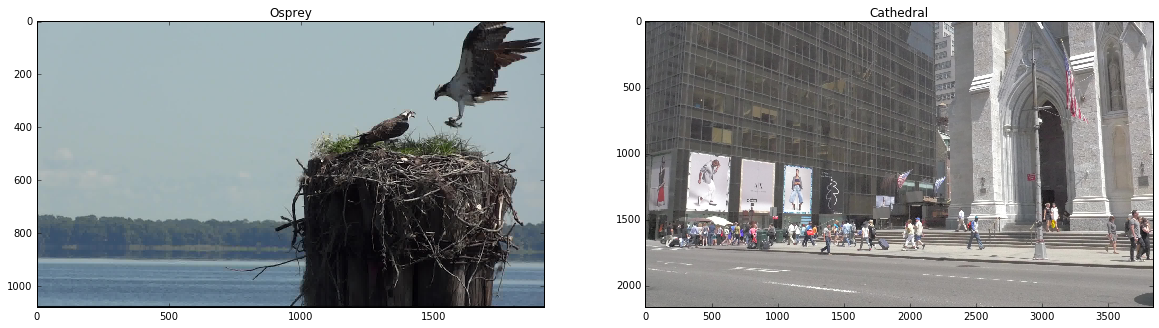

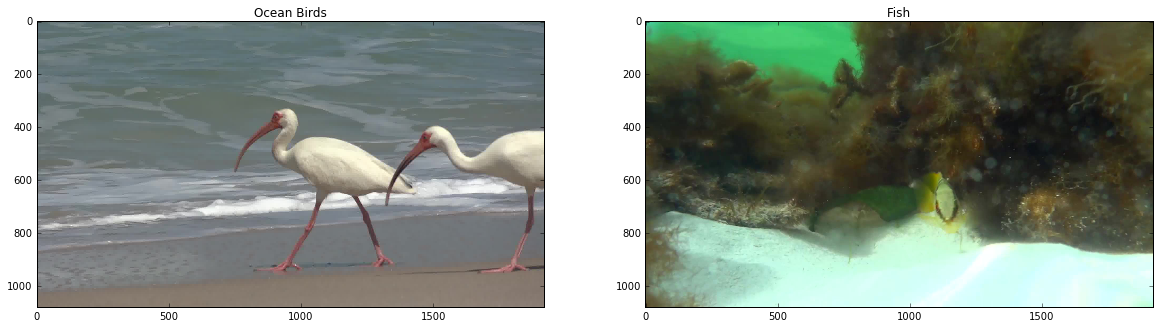

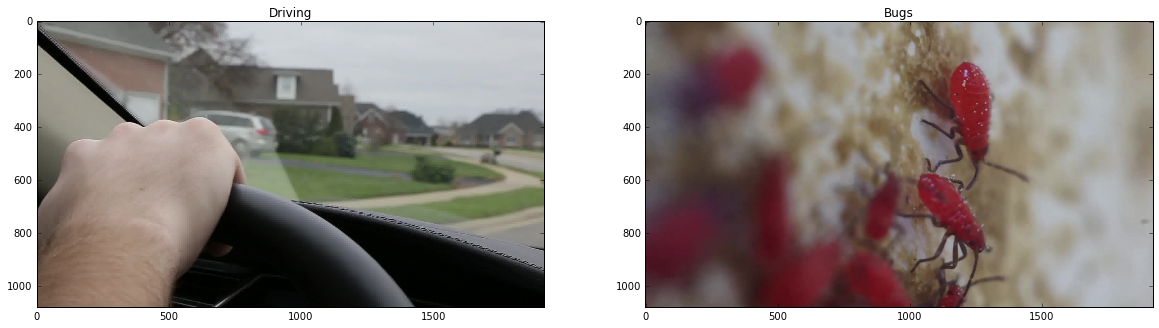

In [108]:
imcompare('osprey_raw.jpg','cathedral_raw.jpg', 'Osprey', 'Cathedral', 'jet', 'jet')
imcompare('ocean_birds_raw.jpg','tropicalfish_raw.jpg', 'Ocean Birds', 'Fish', 'jet', 'jet')
imcompare('SteeringWheel_raw.jpg','redbugs_raw.jpg', 'Driving', 'Bugs', 'jet', 'jet')

**Osprey**

Simple scene, the only real motion is the bird landing in the nest. The camera is fixed in relation to the background and the background is almost entirely static.

**Cathedral**

A complex scene with lots of people and buildings moving. The camera pans upward causing everything to shift in frame making the background chaotic.

**Ocean Birds**

Another simple scene similar to the Osprey clip except the background fluctuates as the waves crash on the shore.

**Fish**

A deceptively complicated scene where the camera loosely tracks the fish. Lots of foreground and background movement combine with the camera's motion making this clip surprisingly difficult to analyze.


**Driving**

A scene where the camera is fixed in relation to the foreground. The car drives slowly so there isn't too much motion blur on the background. The background is a mix of chaotic and fluctuating depending on if the car is turning or not.

**Bugs**

A fixed camera scene with a static background, but with lots of moving objects in the foreground.

**Image differences**



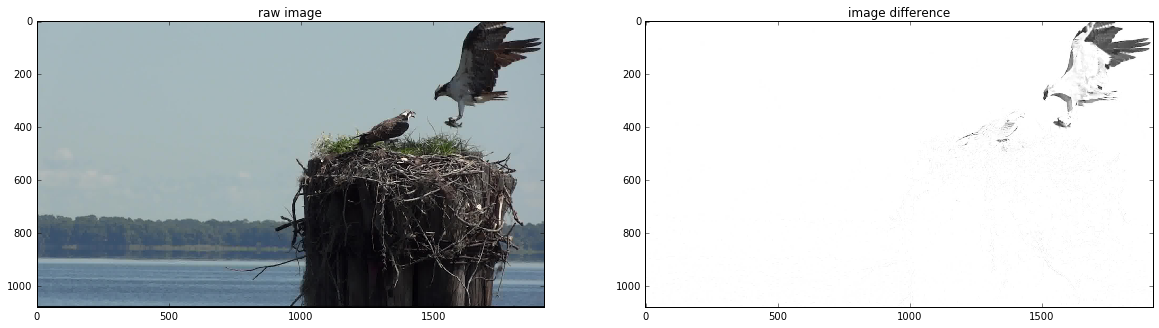

In [109]:
imcompare('osprey_raw.jpg','osprey_diff.jpg', 'raw image', 'image difference')

Image differences make it very apparent which parts of the frame change. The darker the region the more it changed between frames.

**Different kinds of canny edge detection**

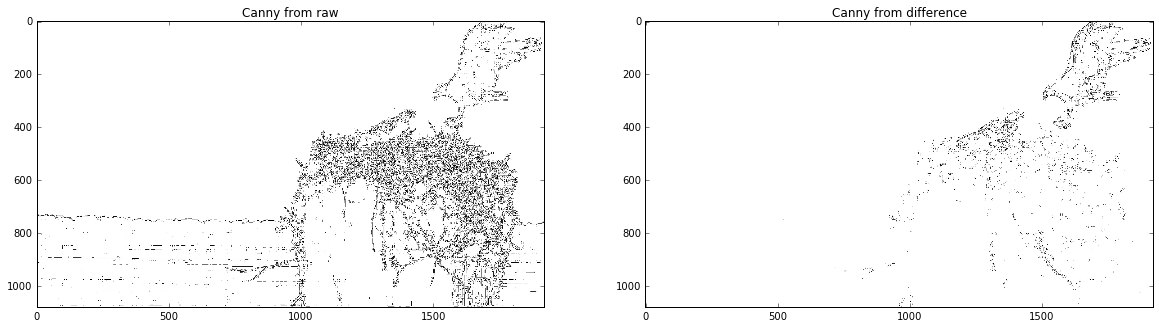

In [110]:
imcompare('osprey_canny.jpg','osprey_cannydiff.jpg', 'Canny from raw' , 'Canny from difference')

While hard to tell from this small image, running the Canny edge detection algorithm on the raw image and the difference of images provides distinct information. The Canny from raw helps provide an approximation of object boundaries. The Canny from difference provides us with what can be thought of as a transformation of the boundaries between frames. If you look cloesly you'll see a leading and trailing "edge" to the "countours" from the previous frame. With a little more feature engineering it seems possible to extract closed loop contours that provide a surjective motion mapping function. There's a lot to be developed there, but initial results are promising.

**Image segmentation failure**

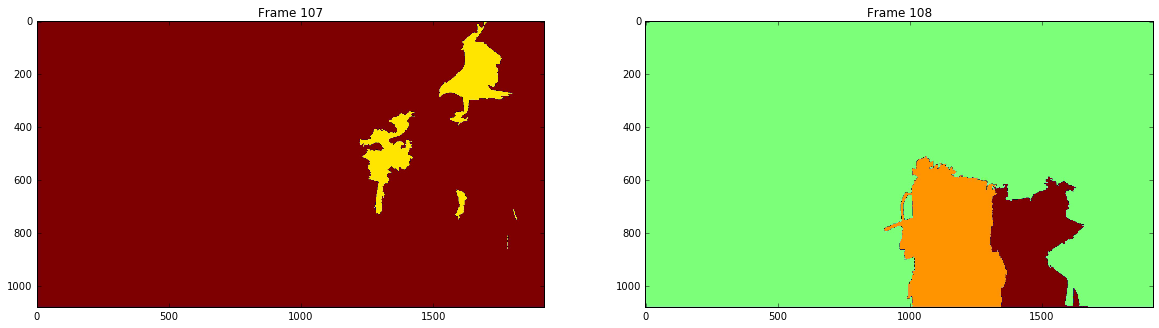

In [111]:
imcompare('osprey_seggood.jpg','osprey_segmented.jpg', 'Frame 107', 'Frame 108', 'jet', 'jet')

These images were generated by running the watershed algorithm on two consecutive frames. The first image gives fairly good segmentation for the what is in the raw image. The second image gives almost no useful information and what's worse is it bears little resemblence the to previous frame, which breaks our assumption about interpolation.

The watershed algorithm can produce excellent results if the conditions of the image are just right. However, the images from the clips I used seemed to be too complex for it to handle well. Potentially, we could change the thresholding levels to calculate it more accurately, but it ends up being a very expensive operation then. As it stands, this is the most time consuming step. It takes nearly a second to run per frame, which makes it unusable if we are to acheive our BHAG.

**Diffs to show motion**

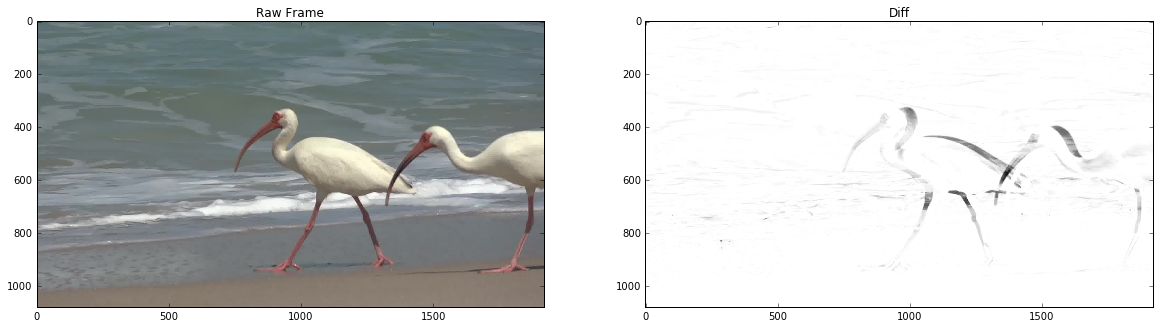

In [112]:
imcompare('ocean_birds_raw.jpg','ocean_birds_diff.jpg', 'Raw Frame', 'Diff', 'jet', 'Greys')

# (underdevelopment for next semester)

Contruct KD-Tree/Voronoi generator
Closed Contour Surjective Map Function, best fit orthogonal line spiral detection
Moving_object Class

## Base Image Processing Methods and Algorithms

Hough Transform

Canny Edge Detection



## Previous Algorithms

Optical Flow,

Kalman Filter

Particle Filtering

Meanshift/Camshift

## New Method of Object Tracking

### References

In [ ]:
OPENCV tutorials
Links forthcoming
StackOverflowv
Links forthcoming